In [1]:
# Importing standard Qiskit libraries:
import numpy as np     
from qiskit import*# QuantumCircuit, transpile, Aer, IBMQ, execute, assemble
#from qiskit.providers.ibmq import least_busy
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from scipy import sparse
from scipy.linalg import sqrtm
# Loading your IBM Quantum account(s):
#provider = IBMQ.load_account()

# Discrete Brillouin zone

In [2]:
number_of_mesh_points = 20
# discretizing the BZ into mesh points.
k_x_lst = list(np.linspace(-np.pi,np.pi,number_of_mesh_points))
k_y_lst = list(np.linspace(-np.pi,np.pi,number_of_mesh_points))

# list of all points in the discrete BZ.
discretized_Brillouin_zone = []
for i in range(number_of_mesh_points-1):
    for j in range(number_of_mesh_points-1):
        discretized_Brillouin_zone.append([k_x_lst[i],k_y_lst[j]])
# nearest neighbor spacing in the discrete BZ.        
delta_k_x = k_x_lst[1]-k_x_lst[0]
delta_k_y = k_y_lst[1]-k_y_lst[0]        

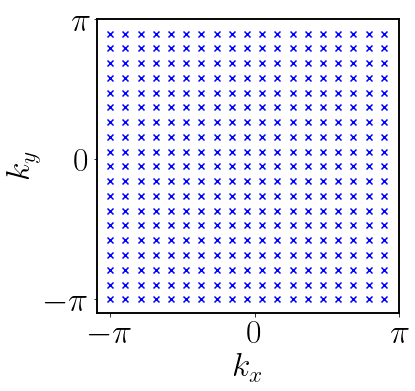

In [3]:
import matplotlib.pyplot as plt
large = 40; med = 34; small = 20
params = {'axes.titlesize': med,
          'axes.titlepad' : med,
          'legend.fontsize': med,
          'axes.labelsize': med ,
          'axes.titlesize': med ,
          'xtick.labelsize': med ,
          'ytick.labelsize': med ,
          'figure.titlesize': med}
plt.rcParams['text.usetex'] = True
#plt.rcParams['text.latex.preamble'] = r'\usepackage{{amsmath}}'
plt.rcParams.update(params)
f = plt.figure()
f.set_figwidth(6)
f.set_figheight(6)
for points in discretized_Brillouin_zone:
    plt.scatter(points[0],points[1],c="b",marker="x")
plt.xlabel(r"$k_{x}$")
plt.ylabel(r"$k_{y}$")    
ax = f.gca()
for spine in ax.spines.values():
    spine.set_linewidth(1.9)
plt.gcf().subplots_adjust(bottom=0.2)

# alternate option without .gcf
plt.subplots_adjust(left=0.2)
x_positions = [-3.14,0,3.14]
x_labels = ["$-\pi$","$0$","$\pi$"]
ax.set_xticks(x_positions)
ax.set_xticklabels(x_labels)
y_positions = [-3.14,0,3.14]
y_labels = ["$-\pi$","$0$","$\pi$"]
ax.set_yticks(y_positions)
ax.set_yticklabels(y_labels)
#plt.savefig("discretized_Brillouin_zone_20.jpg", dpi=600)    
plt.show()

## Custom mesh grid

In [4]:
mesh_grid_lst = [
    [(0,0),(1,0)],
    [(0,0),(0,7)],
    [(0,0),(7,0)],
    [(0,1),(1,1)],
    [(0,1),(0,2)],
    [(0,1),(7,1)],
    [(0,2),(1,2)],
    [(0,2),(2,3)],
    [(0,2),(7,2)],
    [(0,3),(1,3)],
    [(0,3),(3,4)],
    [(0,3),(7,3)],
    [(0,4),(1,4)],
    [(0,4),(4,5)],
    [(0,4),(7,4)],
    [(0,5),(1,5)],
    [(0,5),(5,6)],
    [(0,5),(7,5)],
    [(0,6),(1,6)],
    [(0,6),(6,7)],
    [(0,6),(7,6)],
    [(0,7),(7,1)],
    [(0,7),(7,7)],
    [(7,1),(7,3)],
]
for x in range(1,7):
    for y in range(1,7):
        mesh_grid_lst.append([(x,y),(x+1,y)])
        mesh_grid_lst.append([(x,y),(x,y+1)])
len(mesh_grid_lst)

96

In [5]:
r"""
# k_x and k_y
k_x,k_y = k_x_lst[point_index],k_y_lst[point_index]
# k+delta_k_x and k+delta_k_y

F_k_lst_of_points = [[(k_x,k_y),(k_x+delta_k_x,k_y)],
[(k_x+delta_k_x,k_y),(k_x+delta_k_x,k_y+delta_k_y)],
[(k_x,k_y+delta_k_y),(k_x+delta_k_x,k_y+delta_k_y)],
[(k_x,k_y),(k_x,k_y+delta_k_y)]]""";

# Preparation of the wavefunction at point $\mathbf{k}$

## $U_{3}$ gate

In [6]:
# U_{3} is required for preparing the state |\psi(\theta)>
def U3(theta,lamb,phi):
    return np.array([[np.cos(theta/2),-np.sin(theta/2)*np.exp(1j*lamb)],
                     [np.exp(1j*phi)*np.sin(theta/2),np.exp(1j*(lamb+phi))*np.cos(theta/2)]])

## Defining the two angles $\theta$ and $\phi$

In [7]:
def angle_theta(k_x,k_y,mu):
    E_p = np.sqrt((np.sin(k_y))**2+(np.sin(k_x))**2+(np.cos(k_x)+np.cos(k_y)+mu)**2)
    return np.arccos((np.cos(k_x)+np.cos(k_y)+mu)/E_p)
def angle_phi(k_x,k_y):
    return np.arccos(np.sin(k_y)/np.sqrt((np.sin(k_y))**2+(np.sin(k_x))**2))

## Controlled W gate required for controlled $U_{3}$ operation

In [8]:
def controlled_W(unitary_matrix,c,t):
    I2 = np.identity(2)
    Z = np.matrix([[1,0],[0,-1]])
    X = np.matrix([[0,1],[1,0]])
    PI_0 = (I2+Z)/2
    PI_1 = (I2-Z)/2
    
    if c == 1:
        return np.kron(unitary_matrix,np.kron(PI_1,I2))+np.kron(I2,np.kron(PI_0,I2))
    elif c == 0:
        return np.kron(unitary_matrix,np.kron(I2,PI_1))+np.kron(I2,np.kron(I2,PI_0))
    
def controlled_U3(theta,lamb,phi):
    
    CU3_matrix = np.matrix([[1,0,0,0],
                            [0,np.cos(theta/2),0,-np.sin(theta/2)*np.exp(1j*lamb)],
                            [0,0,1,0],
                            [0,np.exp(1j*phi)*np.sin(theta/2),0,np.exp(1j*(lamb+phi))*np.cos(theta/2)]])
    return CU3_matrix

## Constructing the upper band wavefunction circuit

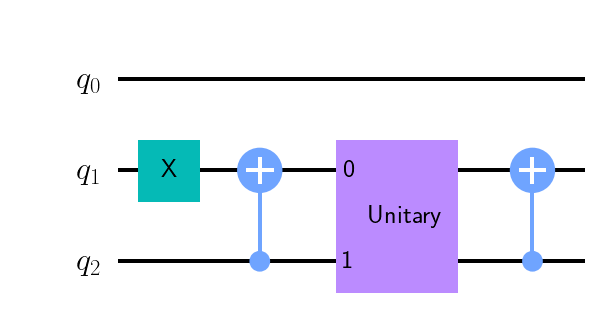

In [9]:
def upper_band_wavefunction(k_x,k_y,mu):

    qc = QuantumCircuit(3)  
    
    qc.x(1)
    qc.cx(2,1)
    theta = angle_theta(k_x,k_y,mu)
    phi = angle_phi(k_x,k_y)
    qc.unitary(controlled_U3(theta,-phi,phi),[1,2])    
    qc.cx(2,1)  
    return qc

"""k_x = 1
k_y = 1
mu = 1
#Changing the simulator 
backend = Aer.get_backend('unitary_simulator')

#The circuit without measurement
qc = QuantumCircuit(2)      
#qc.x(0)
qc.cx(1,0)
theta = angle_theta(k_x,k_y,mu)
phi = angle_phi(k_x,k_y)
qc.unitary(controlled_U3(theta,-phi,phi),[0,1])    
qc.cx(1,0)

#job execution and getting the result as an object
job = execute(qc, backend)
result = job.result()

#get the unitary matrix from the result object
print(result.get_unitary(qc, decimals=3))""";
upper_band_wavefunction(1,1,1).draw("mpl",scale=2,style="clifford")

In [10]:
"""I2 = np.identity(2)
Z = np.matrix([[1,0],[0,-1]])
X = np.matrix([[0,1],[1,0]])
PI_0 = (I2+Z)/2
PI_1 = (I2-Z)/2 
theta = angle_theta(k_x,k_y,mu)
phi = angle_phi(k_x,k_y)
#CNOT = np.kron(I2,PI_0)+np.kron(X,PI_1)
CNOT = np.kron(PI_0,I2)+np.kron(PI_1,X)
np.around(CNOT@controlled_U3(theta,-phi,phi)@CNOT,3)""";

In [11]:
"""def V(k_x,k_y,mu):
    theta = angle_theta(k_x,k_y,mu)
    phi = angle_phi(k_x,k_y)
    return np.matrix([[1,0,0,0],
                      [0,np.cos(theta/2),-np.sin(theta/2)*np.exp(-1j*phi),0],
                      [0,np.sin(theta/2)*np.exp(1j*phi),np.cos(theta/2),0],
                     [0,0,0,1]])
np.around(V(1,1,1),3)""";

## Constructing the lower band wavefunction circuit

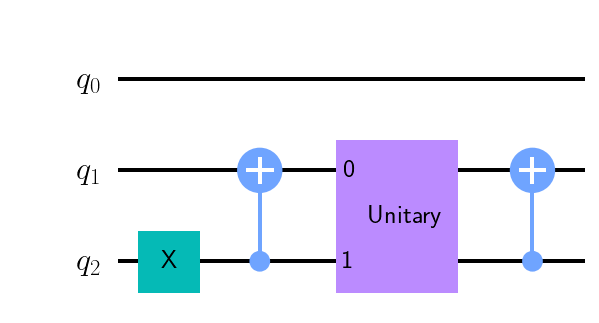

In [12]:
def lower_band_wavefunction(k_x,k_y,mu):
    # Create the quantum circuit
    qc = QuantumCircuit(3)  
    
    qc.x(2)
    qc.cx(2,1) 
    theta = angle_theta(k_x,k_y,mu)
    phi = angle_phi(k_x,k_y)
    
    qc.unitary(controlled_U3(theta,-phi,phi),[1,2])
    
    qc.cx(2,1)    
    return qc
lower_band_wavefunction(0.1,0.2,2.05).draw("mpl",scale=2,style="clifford")

# Relating the wavefunction at two neighboring mesh points

## Intraband evolution circuit

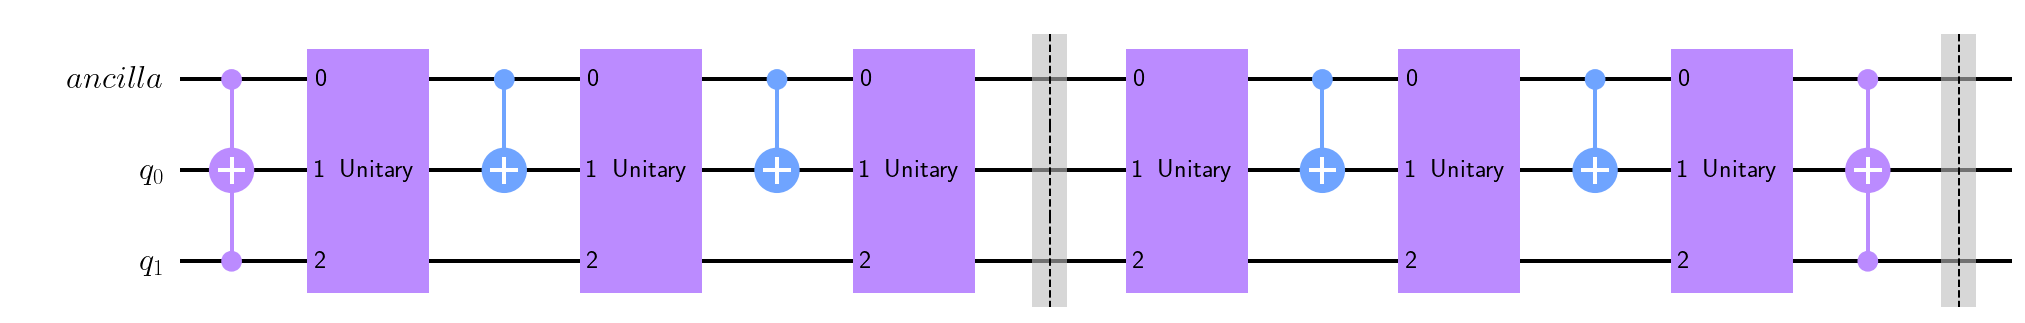

In [13]:
def intraband_evolution(k_x,k_y,k_x_p,k_y_p,mu):

    qr = QuantumRegister(2,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    # Create the quantum circuit
    qc = QuantumCircuit(anc,qr)  
    
    
    qc.ccx(0,2,1)
    
    # k_x k_y
    # $CCU_{3}^{\dagger}$ gate.
    theta_k = angle_theta(k_x,k_y,mu)
    phi_k = angle_phi(k_x,k_y)
    W = sqrtm(U3(theta_k,-phi_k,phi_k).conj().T)
    qc.unitary(controlled_W(W,1,2),[0,1,2])
    qc.cx(0,1)     
    qc.unitary(controlled_W(W.conj().T,1,2),[0,1,2])
    qc.cx(0,1)      
    qc.unitary(controlled_W(W,0,2),[0,1,2])
    
    qc.barrier()
    
    # $CCU_{3}$ gate.
    theta_k_p = angle_theta(k_x_p,k_y_p,mu)
    phi_k_p = angle_phi(k_x_p,k_y_p)
    W = sqrtm(U3(theta_k_p,-phi_k_p,phi_k_p))
    qc.unitary(controlled_W(W,1,2),[0,1,2])
    qc.cx(0,1)      
    qc.unitary(controlled_W(W.conj().T,1,2),[0,1,2])
    qc.cx(0,1)        
    qc.unitary(controlled_W(W,0,2),[0,1,2])
    
    qc.ccx(0,2,1)

    qc.barrier()
    #qc.measure(0,0)
    return qc
intraband_evolution(1,1,1,1,1).draw("mpl",scale=2,style="clifford")

## Interband evolution circuit

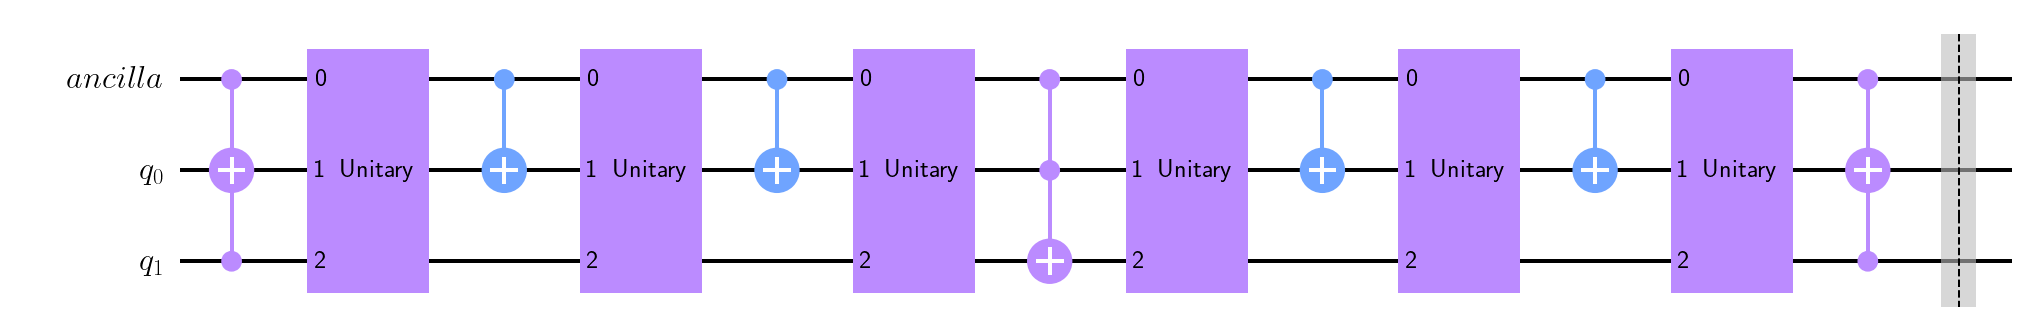

In [14]:
def interband_evolution(k_x,k_y,k_x_p,k_y_p,mu):

    qr = QuantumRegister(2,"q")
    
    # Create the ancilla register
    anc = QuantumRegister(1,"ancilla")
    # Create the quantum circuit
    qc = QuantumCircuit(anc,qr)  
    
    qc.ccx(0,2,1)
    # $CCU_{3}^{\dagger}$ gate.
    theta_k = angle_theta(k_x,k_y,mu)
    phi_k = angle_phi(k_x,k_y)
    W_dag = sqrtm(U3(theta_k,-phi_k,phi_k.conj().T))
    qc.unitary(controlled_W(W_dag,1,2).A,[0,1,2])
    qc.cx(0,1)  
    #W = sqrtm(np.matrix(U3(theta_k,-phi_k,phi_k)))    
    qc.unitary(controlled_W(W_dag.conj().T,1,2).A,[0,1,2])
    qc.cx(0,1)      
    qc.unitary(controlled_W(W_dag,0,2).A,[0,1,2])
    
    qc.ccx(0,1,2)
    
    # $CCU_{3}$ gate.
    theta_k_p = angle_theta(k_x_p,k_y_p,mu)
    phi_k_p = angle_phi(k_x_p,k_y_p)
    W = sqrtm(U3(theta_k_p,-phi_k_p,phi_k_p))
    qc.unitary(controlled_W(W,1,2).A,[0,1,2])
    qc.cx(0,1)      
    #W_dag = sqrtm(np.matrix(U3(theta_k_p,-phi_k_p,phi_k_p).conj().T))
    qc.unitary(controlled_W(W.conj().T,1,2).A,[0,1,2])
    qc.cx(0,1)        
    qc.unitary(controlled_W(W,0,2).A,[0,1,2])
    
    qc.ccx(0,2,1)  
    
    qc.barrier()
    #qc.measure(0,0)
    return qc
interband_evolution(1,1,1,1,1).draw("mpl",scale=2,style="clifford")

# Code on simulator

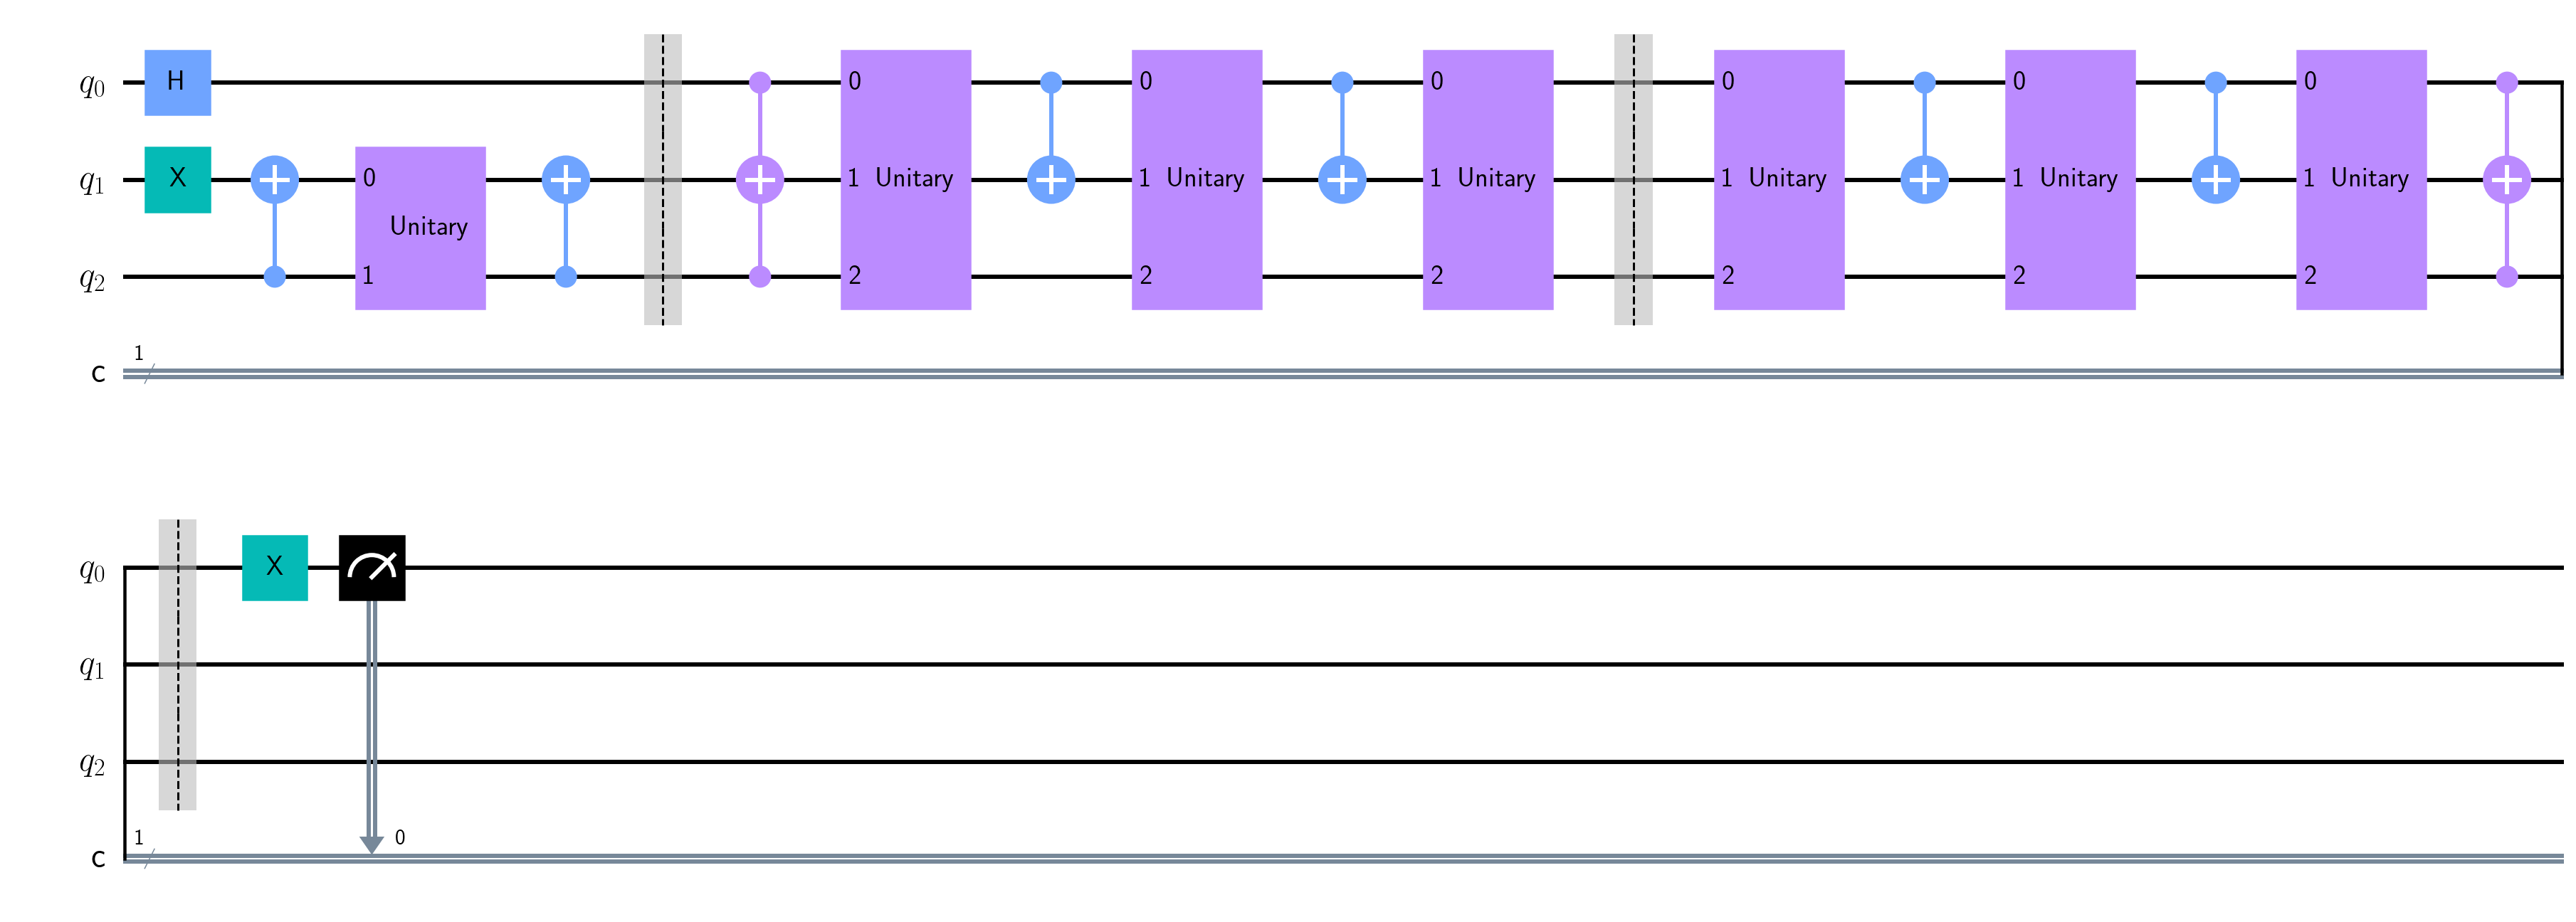

In [15]:
def complete_circuit_real_part(k_x,k_y,k_x_p,k_y_p,mu):

    qc = QuantumCircuit(3,1)     
    #qc.initialize([1,0],0)
    #qc.initialize([1,0],1)    
    qc.h(0)
    qc = qc.compose(upper_band_wavefunction(k_x,k_y,mu))
    #qc = qc.compose(lower_band_wavefunction(k_x,k_y,mu))       
    qc.barrier()
    qc = qc.compose(intraband_evolution(k_x,k_y,k_x_p,k_y_p,mu))
    # only needed for mixed states.
    #qc = qc.compose(interband_evolution(k_x,k_y,k_x_p,k_y_p,mu))  
    qc.x(0)
    #qc.h(0)
    qc.measure(0,0)
    return qc
complete_circuit_real_part(1,1,1,1,1).draw("mpl",scale=3,style = "clifford")

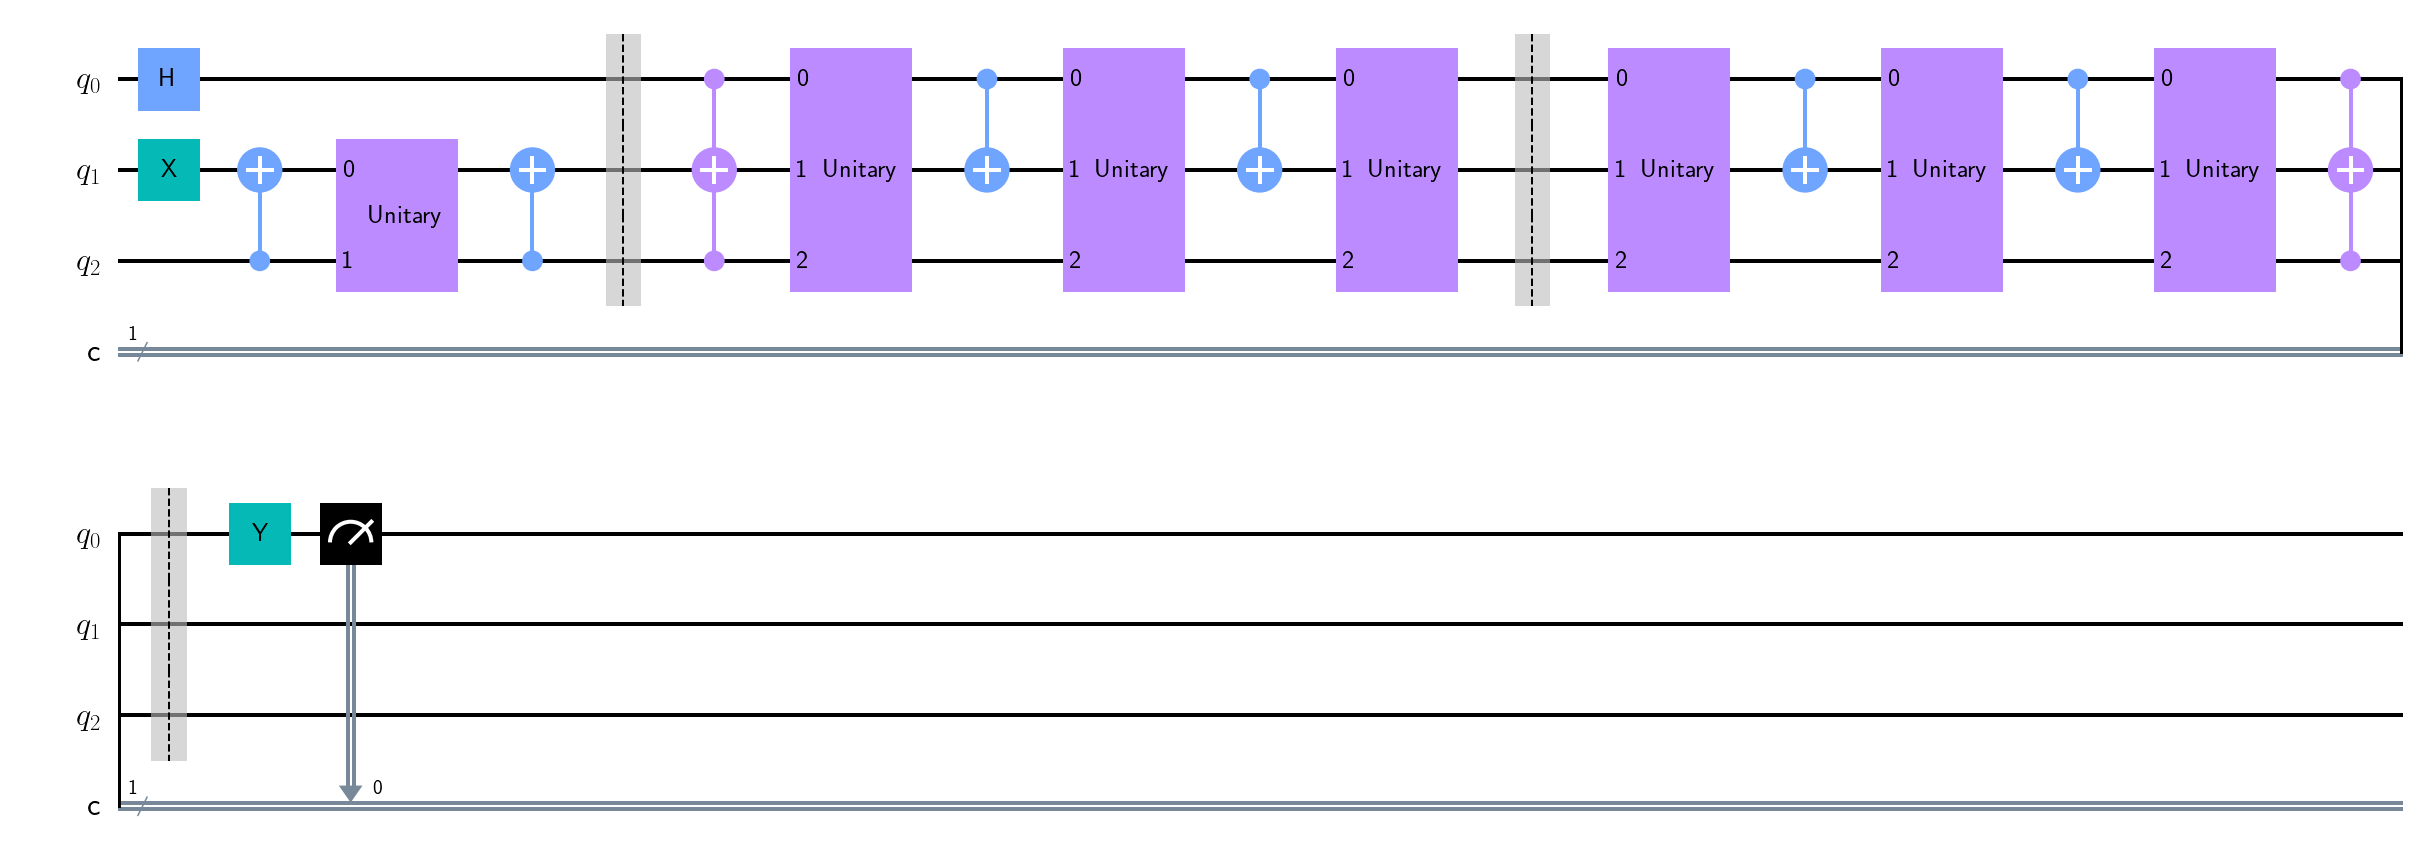

In [16]:
def complete_circuit_imag_part(k_x,k_y,k_x_p,k_y_p,mu):

    qc = QuantumCircuit(3,1)   
    #qc.initialize([1,0],0)
    #qc.initialize([1,0],1)    
    qc.h(0)
    #qc.sdg(0)
    qc = qc.compose(upper_band_wavefunction(k_x,k_y,mu))
    #qc = qc.compose(lower_band_wavefunction(k_x,k_y,mu))    
    qc.barrier()
    qc = qc.compose(intraband_evolution(k_x,k_y,k_x_p,k_y_p,mu))
    #qc = qc.compose(interband_evolution(k_x,k_y,k_x_p,k_y_p,mu))
    #qc.h(0)
    #qc.rx(np.pi/2,0)
    qc.y(0)
    qc.measure(0,0)
    return qc
complete_circuit_imag_part(1,1,1,1,1).draw("mpl",scale=2,style="clifford")

In [17]:
def normalized_overlap(k_x,k_y,k_x_p,k_y_p,mu):
    number_of_shots = 1024
    # real part of the overlap
    backend = Aer.get_backend('qasm_simulator')
    job = execute(transpile(complete_circuit_real_part(k_x,k_y,k_x_p,k_y_p,mu),optimization_level = 2,basis_gates = ["h","cx","rx"]), backend, shots = number_of_shots )
    result = job.result()
    counts_r = result.get_counts()
    try:
        count_r_0 =  counts_r["0"]/number_of_shots 
    except KeyError:
        counts_r_0 = 0
        
    try:
        count_r_1 =  counts_r["1"]/number_of_shots 
    except KeyError:
        count_r_1 = 0

    real_part_of_expectation = count_r_0
    #real_part_of_expectation = 2*count_r_0 - 1
    
    # imaginary part of the overlap
    backend = Aer.get_backend('qasm_simulator')
    job = execute(transpile(complete_circuit_imag_part(k_x,k_y,k_x_p,k_y_p,mu),optimization_level = 2,basis_gates = ["h","cx","rx"]), backend, shots = number_of_shots )
    result = job.result()
    counts_i = result.get_counts()
    
    try:
        count_i_0 =  counts_i["0"]/number_of_shots 
    except KeyError:
        counts_i_0 = 0
        
    try:
        count_i_1 =  counts_i["1"]/number_of_shots 
    except KeyError:
        count_i_1 = 0        
        
    imaginary_part_of_expectation = count_i_0       
    #imaginary_part_of_expectation = 2*count_i_0 - 1   
    
    return real_part_of_expectation + 1j*imaginary_part_of_expectation

In [18]:
mu = -1

In [19]:
Chern_number = 0.0
F_k_lst = []
for k_point_lst in discretized_Brillouin_zone:

    # selecting the point k from the BZ
    k_x_i = k_point_lst[0]
    k_y_i = k_point_lst[1]
    
    # U_1: first point
    k_x   = k_x_i
    k_y   = k_y_i
    k_x_p = k_x_i + delta_k_x
    k_y_p = k_y_i
    
    U_1 = normalized_overlap(k_x,k_y,k_x_p,k_y_p,mu)
    U_1 = U_1/np.abs(U_1)
    
    
    # U_2: second point
    k_x   = k_x_i + delta_k_x
    k_y   = k_y_i
    k_x_p = k_x_i + delta_k_x
    k_y_p = k_y_i + delta_k_y
    
    U_2 = normalized_overlap(k_x,k_y,k_x_p,k_y_p,mu)
    U_2 = U_2/np.abs(U_2)
    
    # U_3: third point
    k_x   = k_x_i
    k_y   = k_y_i + delta_k_y
    k_x_p = k_x_i + delta_k_x
    k_y_p = k_y_i + delta_k_y
    
    U_3 = normalized_overlap(k_x,k_y,k_x_p,k_y_p,mu)
    U_3 = U_3/np.abs(U_3)
        
    # U_4: fourth point
    k_x   = k_x_i
    k_y   = k_y_i
    k_x_p = k_x_i
    k_y_p = k_y_i + delta_k_y
    
    U_4 = normalized_overlap(k_x,k_y,k_x_p,k_y_p,mu)
    U_4 = U_4/np.abs(U_4)
    F_k_lst.append(np.log((U_1*U_2)/(U_3*U_4)))
    Chern_number = Chern_number + np.log((U_1*U_2)/(U_3*U_4))

In [20]:
Chern_number/(2*np.pi*1j)

(0.05001158913053659-3.8237874637377745e-16j)

# Code on hardware

In [21]:
r"""
# Load IBM Q account and get the least busy backend device
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: int(x.configuration().n_qubits) >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)""";

In [22]:
r"""
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
real_hardware_counts_lst = []
for k_1 in k_x_lst:
    for k_2 in k_y_lst:
        F_k_lst_of_points = [[(k_1,k_2),(k_1+delta_k_x,k_2)],
        [(k_1+delta_k_x,k_2),(k_1+delta_k_x,k_2+delta_k_y)],
        [(k_1,k_2+delta_k_y),(k_1+delta_k_x,k_2+delta_k_y)],
        [(k_1,k_2),(k_1,k_2+delta_k_y)]]

        for F_k_index in range(4):
            k_x,k_y = F_k_lst_of_points[F_k_index][0][0],F_k_lst_of_points[F_k_index][0][1]
            k_x_p,k_y_p = F_k_lst_of_points[F_k_index][1][0],F_k_lst_of_points[F_k_index][1][1]
            transpiled_circuit = transpile(intraband_evolution(k_x,k_y,k_x_p,k_y_p), device, optimization_level=3)
            job = device.run(transpiled_circuit)
            job_monitor(job, interval=2)
            # Getting the results from the computation:
            results = job.result()
            answer = results.get_counts(transpiled_circuit)
            #plot_histogram(answer)
            real_hardware_counts_lst.append([k_x,k_y,k_x_p,k_y_p,answer["0"],answer["1"]])""";

# Calculations